In [799]:
import random
import itertools
import matplotlib.pyplot as plt
import networkx as nx

In [800]:
num_columns = 4
grid_size = 30
min_room_size = 3

roomspace = grid_size - (num_columns + 1)
def all_less_then(comb,n):
    for i in comb:
        if i<n:
            return False
    return True

def get_divisions(n, k):
    divisions = []
    combs = itertools.product(range(1, n), repeat=k)
    dic={}
    for comb in combs:
        if sum(comb) == n and all_less_then(comb,min_room_size):
            dic["".join(map(str,sorted(comb)))]=comb
    return list(dic.values())

divisions = get_divisions(roomspace, num_columns)


horizontal_split = list(random.choice(divisions))
vertical_splits = [list(random.choice(divisions)) for i in horizontal_split]
random.shuffle(horizontal_split)
for split in vertical_splits:
    random.shuffle(split)

horizontal_data = []
x_accum = 1
for part in horizontal_split:
    horizontal_data.append((x_accum,part))
    x_accum += part+1

vertical_data = []
for split in vertical_splits:
    y_accum = 1
    data = []
    for part in split:
        data.append((y_accum,part))
        y_accum += part+1
    vertical_data.append(data)
divisions = get_divisions(roomspace, num_columns)

In [801]:
num_rooms = 9

horizontal_split = list(random.choice(divisions))
vertical_splits = [list(random.choice(divisions)) for i in horizontal_split]
random.shuffle(horizontal_split)
for split in vertical_splits:
    random.shuffle(split)

horizontal_data = []
x_accum = 1
for part in horizontal_split:
    horizontal_data.append((x_accum,part))
    x_accum += part+1

vertical_data = []
for split in vertical_splits:
    y_accum = 1
    data = []
    for part in split:
        data.append((y_accum,part))
        y_accum += part+1
    vertical_data.append(data)


chosen_cells = 0
rooms_ixs = []

while True:
    x = random.choice(range(len(horizontal_split)))
    y = random.choice(range(len(vertical_splits[x])))
    ix = (x,y)
    if ix not in rooms_ixs:
        rooms_ixs.append(ix)
    if len(rooms_ixs) == num_rooms:
        break

chosen_rooms = []
for ix_x,ix_y in rooms_ixs:
    x,w = horizontal_data[ix_x]
    y,h = vertical_data[ix_x][ix_y]
    chosen_rooms.append((y,x,h,w))

def get_points(part):
    points = []
    y = part[0]
    x = part[1]
    for i in range(part[2]):
        for j in range(part[3]):
            points.append((y+i,x+j))
    return points
            
    
walkable_points = []
for w in chosen_rooms:
    walkable_points += get_points(w)
walkable_points = set(walkable_points)

def create_string(walkable):
    string = ""
    for i in range(grid_size):
        for j in range(grid_size):
            if (i,j) in walkable:
                string += " "
            else: string += "#"
        string += "\n"
    return string

print(create_string(walkable_points))

##############################
##############################
##############################
##############################
##############################
#########################    #
#########################    #
#####    ################    #
#####    ################    #
#####    #####################
#   #####################    #
#   #####################    #
#   #####################    #
#########################    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   #####################    #
#########################    #
#   #####################    #
#   #####################    #
#   #####################    #
#   ##########################
#   #####################    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
##############################



In [802]:
def toG(y,x):
    return y-1,x-1
def toL(p):
    y,x = p
    return y+1,x+1
def get_room_center(room):
    y,x,h,w=room
    cy = y + (h//2)
    cx = x + (w//2)
    return (cy,cx)

In [803]:
import numpy as np
from scipy.spatial.distance import cdist

def get_distance(r1,r2):
    A = np.array(get_points(r1))
    B = np.array(get_points(r2))
    distances = cdist(A, B)
    min_distance = np.min(distances)
    return min_distance

distances = {}
for i,r1 in enumerate(chosen_rooms):
    for j,r2 in enumerate(chosen_rooms):
        if i<j:
            distances[(i,j)]=get_distance(r1,r2)


In [804]:
sorted_pairs=list(sorted(map(lambda x:(x[0],x[1]),distances.items()),key=lambda x:x[1]))

In [805]:
def get_neighs(p):
    x,y = p
    neighbors = [(x + dx, y + dy) for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]]
    return neighbors

def get_path_border(path):
    border = []
    for p in path:
        border += get_neighs(p)
    surrounding_nodes = list(set(border)-set(path))
    return surrounding_nodes

def get_connecting_edges(surrounding_nodes):
    ret = []
    for node in surrounding_nodes:
        x,y = node
        neighbors = get_neighs((x,y))
        for neighbor in neighbors:
            if neighbor in surrounding_nodes:
                ret.append((node, neighbor))
    return ret

def get_path_border(path):
    border = []
    for p in path:
        border += get_neighs(p)
    surrounding_nodes = list(set(border)-set(path))
    return get_connecting_edges(surrounding_nodes)


def get_room_border(graph, room):
    y, x, h, w = room
    y,x = toG(y,x)
    surrounding_nodes = [(y - 1 + i, x - 1 + j) for i in range(h + 2) for j in range(w + 2) if i in [0, h + 1] or j in [0, w + 1]]
    return get_connecting_edges(surrounding_nodes)


In [806]:
import networkx as nx
G=nx.grid_graph(dim=[grid_size-2,grid_size-2])

for e in G.edges(data=True):
    e[2]['weigth']=1
for n,d in G.nodes(data=True):
    d['taken']=False
for y,x in walkable_points:
    G.nodes[(y-1,x-1)]['taken']=True

def set_weights(G,taken,weigth):
    for node in taken:
        for k,v in G[node].items(): #edges connected to the node
            if G.nodes[k]['taken']==True: #ignore if the node on the other side is already taken
                  continue
            else:
                v['weigth']+=weigth
    return G

def out_of_bounds(indices):
    for i in indices:
        if i<0 or i>grid_size-3:
            return True
    return False

def set_weight_edges(G,edges,weigth):
    for e in edges:
        indices=set(list(e[0])+list(e[1]))
        if out_of_bounds(indices):
            continue
        if G.nodes[e[0]]['taken']==True or G.nodes[e[1]]['taken']==True:
            continue
        G.edges[e]['weigth']=weigth
    return G 

edges_around_rooms = []
for room in chosen_rooms:
    edges_around_rooms+=get_room_border(G,room)
G = set_weight_edges(G,edges_around_rooms,100)    
rooms_points =  map(lambda x:x[0],filter(lambda d: d[1]['taken'] == True, G.nodes(data=True)))
G = set_weights(G,rooms_points,100)

In [807]:
paths = {}
for pair,_ in sorted_pairs:
    r1 = chosen_rooms[pair[0]]
    r2 = chosen_rooms[pair[1]]
    c1=get_room_center(r1)
    c2=get_room_center(r2)
    path=nx.shortest_path(G, source=c1, target=c2, weight='weigth')
    paths[pair]=path
    for y,x in path:
        G.nodes[(y,x)]['taken']=True
    G = set_weight_edges(G,get_path_border(path),100)
    G=set_weights(G,path,50)

In [808]:
paths

{(0, 1): [(7, 27),
  (8, 27),
  (9, 27),
  (10, 27),
  (11, 27),
  (12, 27),
  (13, 27),
  (14, 27),
  (15, 27),
  (16, 27),
  (17, 27)],
 (1, 2): [(17, 27),
  (16, 27),
  (16, 26),
  (16, 25),
  (16, 24),
  (16, 23),
  (16, 22),
  (16, 21),
  (16, 20),
  (16, 19),
  (16, 18),
  (16, 17)],
 (1, 7): [(17, 27),
  (18, 27),
  (19, 27),
  (20, 27),
  (21, 27),
  (22, 27),
  (23, 27),
  (24, 27),
  (25, 27),
  (26, 27),
  (27, 27)],
 (3, 6): [(25, 2),
  (24, 2),
  (23, 2),
  (22, 2),
  (21, 2),
  (20, 2),
  (19, 2),
  (18, 2),
  (17, 2)],
 (4, 6): [(11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2)],
 (5, 7): [(27, 17),
  (27, 18),
  (27, 19),
  (27, 20),
  (27, 21),
  (27, 22),
  (27, 23),
  (27, 24),
  (27, 25),
  (27, 26),
  (27, 27)],
 (4, 8): [(11, 2),
  (10, 2),
  (10, 3),
  (10, 4),
  (9, 4),
  (8, 4),
  (8, 5),
  (8, 6),
  (8, 7)],
 (1, 5): [(17, 27),
  (17, 26),
  (17, 25),
  (17, 24),
  (18, 24),
  (19, 24),
  (20, 24),
  (21, 24),
  (22, 24),
  (22, 23),
  (22, 22),
  

In [809]:
G.edges[((0,0),(0,1))]

{'weigth': 1}

In [810]:
ix = 3
walkable_points1 = set(list(walkable_points) + list(map(toL,paths[sorted_pairs[ix][0]])))
print(create_string(walkable_points1))

##############################
##############################
##############################
##############################
##############################
#########################    #
#########################    #
#####    ################    #
#####    ################    #
#####    #####################
#   #####################    #
#   #####################    #
#   #####################    #
#########################    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   #####################    #
### #####################    #
#   #####################    #
#   #####################    #
#   #####################    #
#   ##########################
#   #####################    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
##############################



In [811]:
get_path_border(paths[(0,4)])

[((6, 28), (7, 28)),
 ((6, 28), (5, 28)),
 ((1, 17), (1, 18)),
 ((1, 17), (1, 16)),
 ((1, 6), (1, 7)),
 ((1, 6), (1, 5)),
 ((3, 7), (3, 8)),
 ((3, 7), (3, 6)),
 ((1, 11), (1, 12)),
 ((1, 11), (1, 10)),
 ((7, 28), (6, 28)),
 ((1, 1), (1, 2)),
 ((1, 1), (1, 0)),
 ((3, 2), (3, 3)),
 ((3, 2), (3, 1)),
 ((8, 2), (8, 1)),
 ((3, 23), (4, 23)),
 ((3, 23), (3, 22)),
 ((9, 3), (10, 3)),
 ((5, 24), (5, 25)),
 ((6, 26), (7, 26)),
 ((6, 26), (5, 26)),
 ((3, 12), (3, 13)),
 ((3, 12), (3, 11)),
 ((1, 12), (1, 13)),
 ((1, 12), (1, 11)),
 ((3, 1), (4, 1)),
 ((3, 1), (3, 2)),
 ((6, -1), (7, -1)),
 ((6, -1), (5, -1)),
 ((3, 18), (3, 19)),
 ((3, 18), (3, 17)),
 ((1, 21), (1, 22)),
 ((1, 21), (1, 20)),
 ((3, 11), (3, 12)),
 ((3, 11), (3, 10)),
 ((1, 15), (1, 16)),
 ((1, 15), (1, 14)),
 ((7, -1), (8, -1)),
 ((7, -1), (6, -1)),
 ((5, 1), (6, 1)),
 ((5, 1), (4, 1)),
 ((3, 17), (3, 18)),
 ((3, 17), (3, 16)),
 ((10, 3), (11, 3)),
 ((10, 3), (9, 3)),
 ((4, -1), (5, -1)),
 ((4, -1), (3, -1)),
 ((1, 16), (1, 17)),

In [812]:
paths_lst = [(k, v) for k, v in paths.items()]

transformed_points = []
for room in chosen_rooms:
    points = get_points(room)
    transformed_points.append(list(map(lambda x:toG(x[0], x[1]), points)))
    

def checkIntersection(setA, setB):
    intersection = setA.intersection(set(setB).union(set(get_path_border(setB))))
    if len(intersection) > 0:
        return True
    return False



In [813]:
import itertools
import networkx as nx
edge_id = 0
# 1
room_G = nx.Graph()
for i, room in enumerate(chosen_rooms):
    room_G.add_node(i, room=room)
# 2
for corridor_key, corridor_points in paths_lst:
    start_room_index = corridor_key[0]
    end_room_index = corridor_key[1]
    # 3
    corridor_points = set(corridor_points)
    # 4, 5, 6
    start_room_points = set(transformed_points[start_room_index])
    end_room_points = set(transformed_points[end_room_index])
    corridor_points -= start_room_points
    corridor_points -= end_room_points

    # 7
    crossed_corridors = []
    crossed_rooms = []
    for i, room in enumerate(transformed_points):
        room_points = set(room)
        if checkIntersection(room_points, corridor_points):
            crossed_rooms.append(i)

    for j, path in enumerate(paths_lst):
        if edge_id == j:
            continue
        path_points = set(path[1])
        if checkIntersection(path_points, corridor_points):
            crossed_corridors.append(j)
    room_G.add_edge(start_room_index, end_room_index, corridor_key=edge_id, crossed_corridors=crossed_corridors, crossed_rooms=crossed_rooms)
    edge_id += 1
    #print(corridor_key)
print(corridor_key)
print(start_room_index, end_room_index)

(4, 7)
4 7


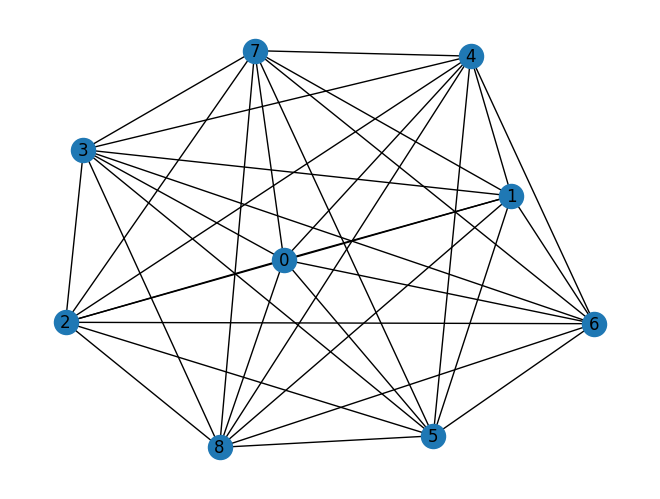

In [814]:
nx.draw(room_G, with_labels=True)
edgs=room_G.edges(data=True)

In [815]:
for e in edgs:
    print(e)

(0, 1, {'corridor_key': 0, 'crossed_corridors': [21, 25], 'crossed_rooms': []})
(0, 2, {'corridor_key': 10, 'crossed_corridors': [23, 27, 33, 34, 35], 'crossed_rooms': []})
(0, 7, {'corridor_key': 21, 'crossed_corridors': [0, 1, 2, 7, 23, 25, 26, 27, 28], 'crossed_rooms': [1]})
(0, 8, {'corridor_key': 22, 'crossed_corridors': [8, 13, 19, 23, 24, 27, 33, 35], 'crossed_rooms': []})
(0, 5, {'corridor_key': 25, 'crossed_corridors': [0, 1, 7, 14, 21, 23, 26, 27, 28, 33, 35], 'crossed_rooms': [1]})
(0, 4, {'corridor_key': 30, 'crossed_corridors': [31], 'crossed_rooms': []})
(0, 6, {'corridor_key': 31, 'crossed_corridors': [30], 'crossed_rooms': [4]})
(0, 3, {'corridor_key': 34, 'crossed_corridors': [8, 10, 11, 13, 15, 18, 19, 20, 23, 24, 27, 28, 32, 33, 35], 'crossed_rooms': [2]})
(1, 2, {'corridor_key': 1, 'crossed_corridors': [14, 28], 'crossed_rooms': []})
(1, 7, {'corridor_key': 2, 'crossed_corridors': [21], 'crossed_rooms': []})
(1, 5, {'corridor_key': 7, 'crossed_corridors': [25, 26], 

In [816]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def _expand(G, explored_nodes, explored_edges):
    """
    Expand existing solution by a process akin to BFS.

    Arguments:
    ----------
    G: networkx.Graph() instance
        full graph

    explored_nodes: set of ints
        nodes visited

    explored_edges: set of 2-tuples
        edges visited

    Returns:
    --------
    solutions: list, where each entry in turns contains two sets corresponding to explored_nodes and explored_edges
        all possible expansions of explored_nodes and explored_edges

    """
    frontier_nodes = list()
    frontier_edges = list()
    for v in explored_nodes:
        for u in nx.neighbors(G,v):
            if not (u in explored_nodes):
                frontier_nodes.append(u)
                frontier_edges.append([(u,v), (v,u)])

    return zip([explored_nodes | frozenset([v]) for v in frontier_nodes], [explored_edges | frozenset(e) for e in frontier_edges])

def find_all_spanning_trees(G, root=0):
    """
    Find all spanning trees of a Graph.

    Arguments:
    ----------
    G: networkx.Graph() instance
        full graph

    Returns:
    ST: list of networkx.Graph() instances
        list of all spanning trees

    """

    # initialise solution
    explored_nodes = frozenset([root])
    explored_edges = frozenset([])
    solutions = [(explored_nodes, explored_edges)]
    # we need to expand solutions number_of_nodes-1 times
    for ii in range(G.number_of_nodes()-1):
        # get all new solutions
        solutions = [_expand(G, nodes, edges) for (nodes, edges) in solutions]
        # flatten nested structure and get unique expansions
        solutions = set([item for sublist in solutions for item in sublist])

    return [nx.from_edgelist(edges) for (nodes, edges) in solutions]

In [817]:
def get_valid_skeletons(G_room, room_indices):
    group = G_room.subgraph(room_indices)
    #nx.draw(group, with_labels=True)
    all_spanning_trees = find_all_spanning_trees(group, root=room_indices[0])
    valid_skeletons = []
    for spanning_tree in all_spanning_trees:
        edges = list(spanning_tree.edges())
        intersections = []
        corridor_keys = []
        valid_skeleton = True
        for edge_id in edges:
            edge = G_room[edge_id[0]][edge_id[1]]
            if all(n in room_indices for n in edge["crossed_rooms"]):
                intersections += edge["crossed_corridors"]
                corridor_keys.append(edge["corridor_key"])
            else:
                valid_skeleton = False
        if valid_skeleton:
            valid_skeletons.append({"edges": set(corridor_keys), "intersections": set(intersections)})
    return valid_skeletons



In [818]:
import itertools

available_indices = set(range(num_rooms))

def get_group_skeletons(available,group_size):
    combs = list(itertools.combinations(available,group_size))
    for c in combs:
        skels = get_valid_skeletons(room_G, list(c))
        if len(skels)!=0:
            yield (set(c),skels)
    return (False,False)

In [819]:
def iterate_G(available,group_sizes,i):
    group_size = group_sizes[0]
    group_sizes = group_sizes[1:]
    iterator = get_group_skeletons(available,group_size)
    for ixs,skels in iterator:
        if ixs == False:
            return []
        if len(group_sizes)!=0:
            available_ = available-ixs
            iterator_ = iterate_G(available_,group_sizes,i+1)
            finished = False
            for groups in iterator_:
                if len(groups) != 0:
                    groups.append({'vertices':ixs,'skeletons':skels})
                    yield groups
                else:
                    yield []
        else:
            yield [{'vertices':ixs,'skeletons':skels}] 

In [820]:
def get_possible_split(groups,intersections=set(),i=0):
    group = groups[0]
    if len(groups)==1:
        groups = []
    else:
        groups = groups[1:]
    for s1 in group['skeletons']:
        if len(s1['edges'].intersection(intersections))==0: # good
            if len(groups)!=0:
                it = get_possible_split(groups,intersections.union(s1['intersections']),i=i+1)
                for s2 in it:
                    s2.append(s1)
                    yield s2
            else:
                yield [s1]
        else:
            yield []
    return []

In [821]:
splits_it = iterate_G(available_indices,[3,3,3],0)
found = False
for i,split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels)==3:
            found = True
            print(i,'::::',skels)
            break
    #if i>100:
    if found==True:
        break

1 :::: [{'edges': {0, 1}, 'intersections': {25, 28, 21, 14}}, {'edges': {5, 29}, 'intersections': {7, 12, 16, 18, 20, 24, 25, 26}}, {'edges': {4, 6}, 'intersections': {17, 20, 9}}]


In [822]:
skels

[{'edges': {0, 1}, 'intersections': {14, 21, 25, 28}},
 {'edges': {5, 29}, 'intersections': {7, 12, 16, 18, 20, 24, 25, 26}},
 {'edges': {4, 6}, 'intersections': {9, 17, 20}}]

In [823]:
vertices_edges_dict = nx.get_edge_attributes(room_G,'corridor_key')
vertices_edges_dict_inv = {v: k for k, v in vertices_edges_dict.items()}

In [824]:
print(vertices_edges_dict_inv)

{0: (0, 1), 10: (0, 2), 21: (0, 7), 22: (0, 8), 25: (0, 5), 30: (0, 4), 31: (0, 6), 34: (0, 3), 1: (1, 2), 2: (1, 7), 7: (1, 5), 23: (1, 8), 26: (1, 3), 27: (1, 4), 28: (1, 6), 8: (2, 8), 11: (2, 6), 13: (2, 4), 14: (2, 7), 15: (2, 3), 16: (2, 5), 3: (3, 6), 12: (3, 5), 17: (3, 4), 19: (3, 8), 29: (3, 7), 4: (4, 6), 6: (4, 8), 20: (4, 5), 35: (4, 7), 5: (5, 7), 18: (5, 6), 24: (5, 8), 9: (6, 8), 32: (6, 7), 33: (7, 8)}


In [825]:
def get_vertices_from_edge_ids(vertices_edges_dict, skels):
    skel_vertices = {}
    if type(skels) == list:
        for skel in skels:
            skel_edges = skel['edges']
            for edge_id in skel_edges:
                skel_vertices[edge_id] = vertices_edges_dict[edge_id]
    else:
        skel_edges = skels['edges']
        for edge_id in skel_edges:
            skel_vertices[edge_id] = vertices_edges_dict[edge_id]
    return skel_vertices

In [826]:
def get_edge_ids_from_vertices(vertex_tuples, vertices_edges_dict):
    edge_ids = []
    for vertex_tuple in vertex_tuples:
        for edge_id, edge_vertices in vertices_edges_dict.items():
            if vertex_tuple == edge_vertices:
                edge_ids.append(edge_id)
    return edge_ids

In [827]:
# skels is a list of skeletons for each group such as the one in the cell above
# [{'edges': {0, 12}, 'intersections': {15, 21, 24, 25, 28, 29}},
# {'edges': {5, 34}, 'intersections': {31, 35}},
# {'edges': {9, 10}, 'intersections': {14}}]
# groups is a tuple of indices (i,j) of the groups which should be connected..it uses the skels list indices
# [0,1]
# setA = get all vertices from group i (use get_vertices_from_edge_ids)
# setB = get all vertices from group j (use get_vertices_from_edge_ids)
# create all possible pairs (crossing edges) where the first element is from setA and the second from setB
# iterate over the crossing edges (refered here as e): (itertools)
# now when we speak about corridors we mean corridors which are present in the skeletons in the skel list
# these corridors are stored in the 'edges' key of a given skeleton
# if the crossing_edge e intersects some room or corridor from some other group than i or j then skip this edge (other groups are present in skels list)
# intA = get intersection between the crossing edge e and anything (either room or chosen corridor) in group i
# intB = same thing but for group j
# if both intA and intB are not empty then skip this crossing edge
# else return this edge

In [828]:
groups_to_connect = (0,1)
def get_crossing_edges(skels, groups_to_connect):
    i, j = groups_to_connect

    setA = get_vertices_from_edge_ids(vertices_edges_dict_inv, skels[i])
    setB = get_vertices_from_edge_ids(vertices_edges_dict_inv, skels[j])

    setA_vertices = set([vertex for edge in setA.values() for vertex in edge])
    setB_vertices = set([vertex for edge in setB.values() for vertex in edge])

    crossing_edges = list(itertools.product(setA_vertices, setB_vertices))
    return crossing_edges

crossing_edges = get_crossing_edges(skels, groups_to_connect)
print(crossing_edges)

[(0, 3), (0, 5), (0, 7), (1, 3), (1, 5), (1, 7), (2, 3), (2, 5), (2, 7)]


In [829]:
import itertools
#returns edge id
def get_edges_from_skels(crossing_edges, groups_to_connect):
    i,j = groups_to_connect
    edge_ids = get_edge_ids_from_vertices(crossing_edges, vertices_edges_dict_inv)
    for e in edge_ids:
        skip = False
        for g in range(len(skels)):
            if g not in (i, j):
                if e in skels[g]['edges']:
                    skip = True
                    break
        if skip:
            continue
        intA = e in skels[i]['intersections'] or e in skels[i]['edges']
        intB = e in skels[j]['intersections'] or e in skels[j]['edges']
        print(e, intA, intB)
        if not(intA == False and intB == False):
            continue
        else:
            return e

get_edges_from_skels(crossing_edges, groups_to_connect)

34 False False


34

In [830]:
ix = 14
print(paths_lst[ix][0])
walkable_points1 = set(list(walkable_points) + list(map(toL,paths_lst[ix][1])))
print(create_string(walkable_points1))

(2, 7)
##############################
##############################
##############################
##############################
##############################
#########################    #
#########################    #
#####    ################    #
#####    ################    #
#####    #####################
#   #####################    #
#   #####################    #
#   #####################    #
#########################    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
#   ######                   #
#   ######              #    #
#   #####################    #
#########################    #
#   #####################    #
#   #####################    #
#   #####################    #
#   ###################### ###
#   #####################    #
#   ######              #    #
#   ######              #    #
#   ######              #    #
##############################



In [831]:
paths_lst

[((0, 1),
  [(7, 27),
   (8, 27),
   (9, 27),
   (10, 27),
   (11, 27),
   (12, 27),
   (13, 27),
   (14, 27),
   (15, 27),
   (16, 27),
   (17, 27)]),
 ((1, 2),
  [(17, 27),
   (16, 27),
   (16, 26),
   (16, 25),
   (16, 24),
   (16, 23),
   (16, 22),
   (16, 21),
   (16, 20),
   (16, 19),
   (16, 18),
   (16, 17)]),
 ((1, 7),
  [(17, 27),
   (18, 27),
   (19, 27),
   (20, 27),
   (21, 27),
   (22, 27),
   (23, 27),
   (24, 27),
   (25, 27),
   (26, 27),
   (27, 27)]),
 ((3, 6),
  [(25, 2),
   (24, 2),
   (23, 2),
   (22, 2),
   (21, 2),
   (20, 2),
   (19, 2),
   (18, 2),
   (17, 2)]),
 ((4, 6), [(11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2)]),
 ((5, 7),
  [(27, 17),
   (27, 18),
   (27, 19),
   (27, 20),
   (27, 21),
   (27, 22),
   (27, 23),
   (27, 24),
   (27, 25),
   (27, 26),
   (27, 27)]),
 ((4, 8),
  [(11, 2),
   (10, 2),
   (10, 3),
   (10, 4),
   (9, 4),
   (8, 4),
   (8, 5),
   (8, 6),
   (8, 7)]),
 ((1, 5),
  [(17, 27),
   (17, 26),
   (17, 25),
   (17, 24